In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

df = pd.read_csv('raw_experiments.csv', index_col=0)
for col in df.columns:
    print(col)

experiment
human_role
map
pid
game_time
is_time_success
user number of utterances
user mean utterance length
user total number of tokens
user number of eng utterances
user number of es utterances
user number of mix utterances
user number of none utterances
user number of inter-sentential cs
user number of utterances with some congruent switch
user number of total congruent switches
user number of cong switches
user number of incong1 switches
user number of incong2 switches
user number of NP switches
user number of amb_masc switches
user number of amb_fem switches
user % entrainment - all dialog
user % entrainment - on bot inter-sentential cs
bot number of utterances
bot mean utterance length
bot total number of tokens
bot number of eng utterances
bot number of es utterances
bot number of mix utterances
bot number of none utterances
bot number of inter-sentential cs
bot number of utterances with some congruent switch
bot number of total congruent switches
bot number of cong switches
bot

In [2]:
def get_experiment_df(exp: list[str], role = 'all'):
#     new_df = df[df['experiment'] == exp]
    new_df = df[df['experiment'].isin(exp)]
    if role == 'all':
        return new_df
    return new_df[new_df['human_role'] == role]

def fix_lng_cols(text):
    if type(text) == float:
        return 'NONE'
    text = text.strip().lower()
    if text in ['english', 'enlgish', 'englis', 'eng']:
        return 'ENG'
    if text in ['spanish']:
        return 'ES'
    if 'eng' in text and 'spa' in text:
        return 'BOTH'
    if text in ['portuguese']:
        return 'NONE'
    else:
        return 'NONE'

def remove_rename_columns(df, remove=True):
    questions_rename = {'How much did you enjoy the task?' : 'Q_enjoy',
                        "How successful do you think you were at completing the task?" : 'Q_successful',
                        "How likely would you be to mix languages in the following contexts? Interacting with friends": "Q_mix_friends",
                        'Do you enjoy mixing languages in conversation?': "Q_enjoy_mix",
                        "How natural was your conversational partner’s language switching?": "Q_natural",
                       }
    if remove:
        remove_cols = ['human_role', 'experiment', 'map', 'pid']
        all_cols = list(df.columns)
        remove_cols.extend(list(filter(lambda x: 'bot_' in x, all_cols)))
        df = df.drop(remove_cols, axis=1)
    
    df = df.rename(columns=questions_rename, errors="raise")
    
    
    
    df["English %"] = df["user number of eng utterances"] / df["user number of utterances"] *100 
    df["Spanish %"] = df["user number of es utterances"] / df["user number of utterances"]  *100
    df["Mix %"] = df["user number of mix utterances"] / df["user number of utterances"]  *100
    df["Inter-Sentential CS %"] = df["user number of inter-sentential cs"] / (df["user number of utterances"] - 1)  *100

    df['% entrainment - on bot inter-sentential cs'] = df['user % entrainment - on bot inter-sentential cs'] * 100
    df['% entrainment - all dialog'] = df['user % entrainment - all dialog'] * 100

    # remove custom na
    df = df.drop(df.loc[df['Q_natural'] == 'na'].index)
    df = df.drop(df.loc[df['Q_mix_friends'] == 'na'].index)
    df = df.drop(df.loc[df['Q_enjoy_mix'] == 'na'].index)

    df['Q_mix_friends'] = df['Q_mix_friends'].astype(int)
    df['Q_enjoy_mix'] = df['Q_enjoy_mix'].astype(int)
    df['Q_natural'] = df['Q_natural'].astype(int)

    
    df['lng_1'] = df['Enter your native language, or the language you are providing answers for, here:'].apply(fix_lng_cols)
    df['lng_2'] = df['Enter your most proficient second language here:'].apply(fix_lng_cols)
        
    
    return df


In [3]:
def plot_corr_matt(df, title):
    f = plt.figure(figsize=(15, 15))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title(f'{title} - Correlation Matrix', fontsize=16)

    
def plot_2d_scatter(df, title, x, y, color, size):
    fig = px.scatter(df, x=x, y=y, color=color, size=size, title=title)
    fig.show()

In [4]:
alt_experiments = ['Alternation Baseline', 'Random CS', 'Short-context CS', 'Alignment CS', 'Adversarial CS']
ins_experiments = ['Insertional Spanish Baseline', 'Insertional Spanish Congruent','Insertional Spanish InCongruent1',
                   'Insertional Spanish InCongruent2']
experiments = ins_experiments

feature = 'Q_natural'#'user number of mix utterances'#"% entrainment - all dialog"
for exp in experiments:
    exp_df = get_experiment_df([exp])
    exp_df = remove_rename_columns(exp_df)
    # plot_corr_matt(exp_df, exp)
    for role in ['navigator', 'instructor']:
        exp_df = get_experiment_df([exp], role)
        exp_df = remove_rename_columns(exp_df)
        # plot_corr_matt(exp_df, f'{exp} - {role}')
        
        # if role == 'navigator':
        #     plot_2d_scatter(df=exp_df,
        #     x=feature,
        #     y="dist_score",
        #     color='is_time_success',
        #     size='game_time',
        #     title=f'{exp} - {role}')
        
        

(436, 121)


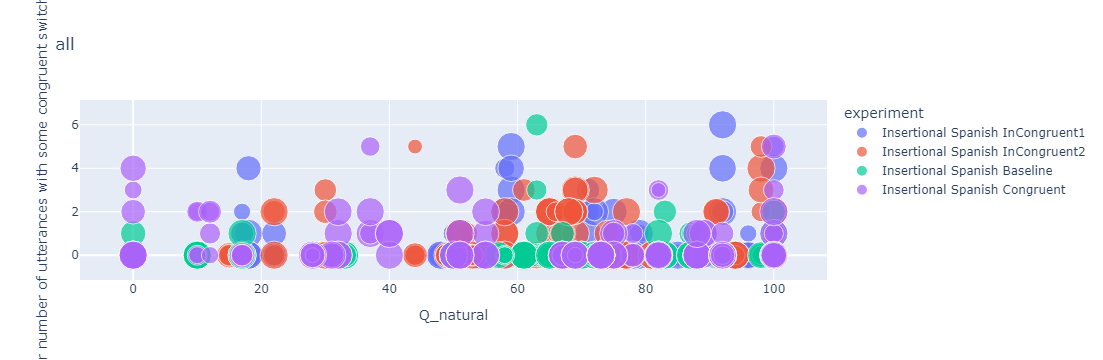

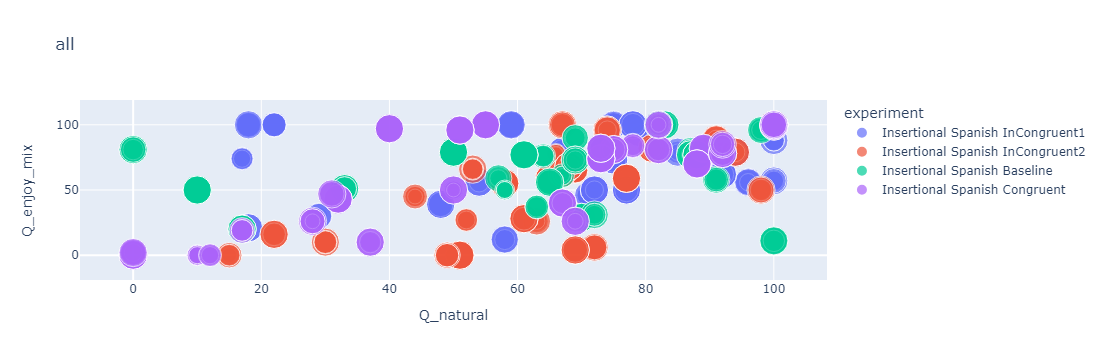

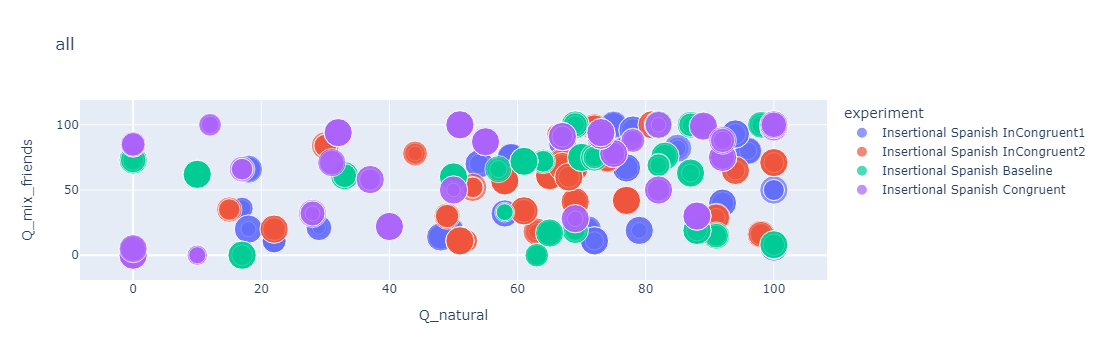

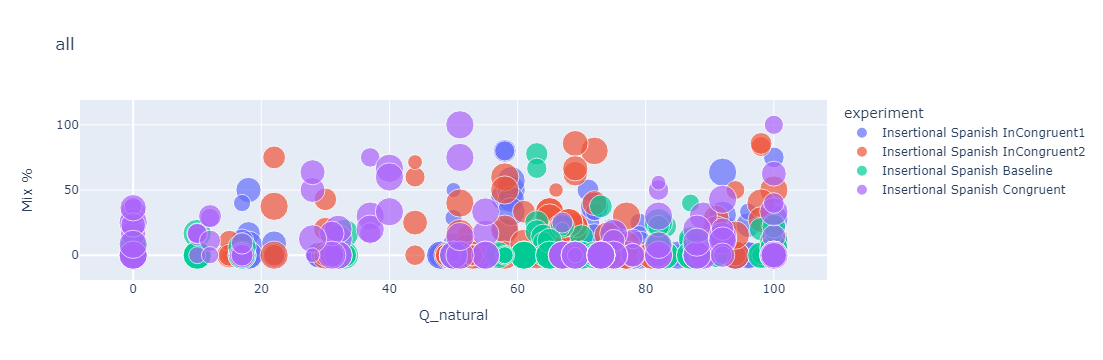

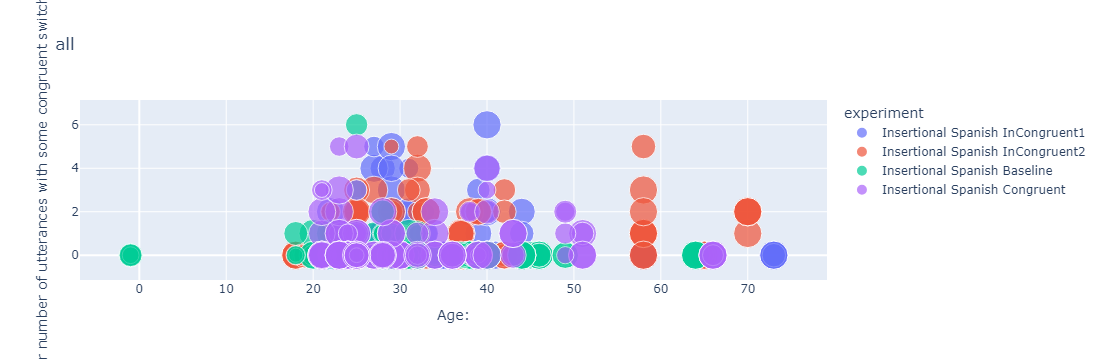

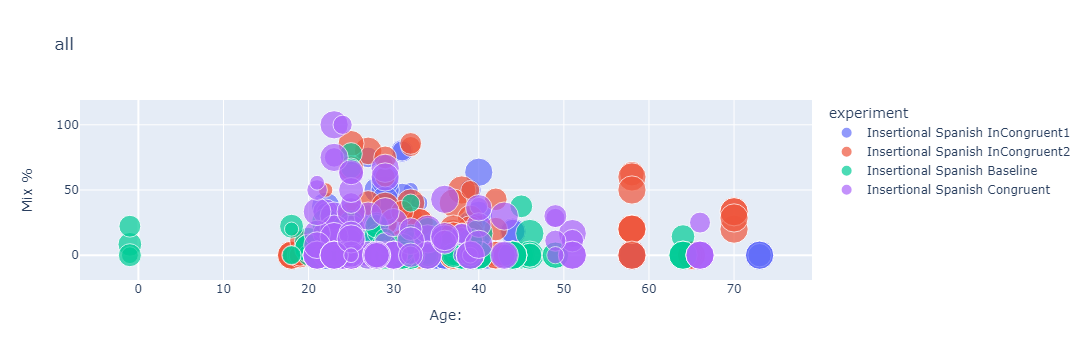

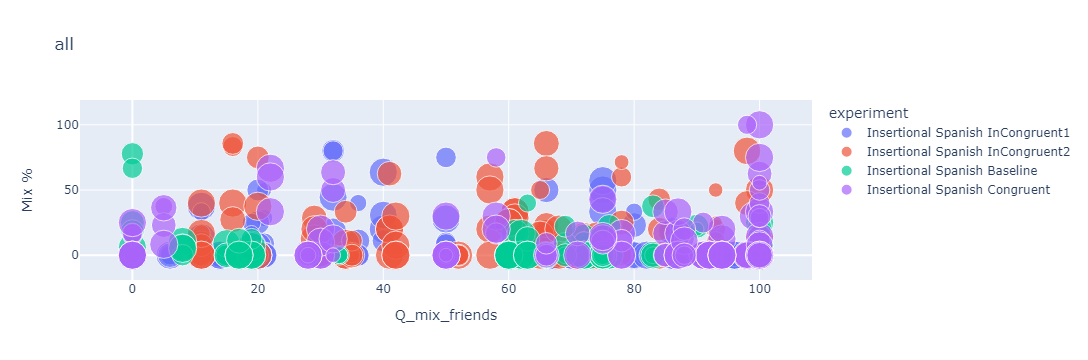

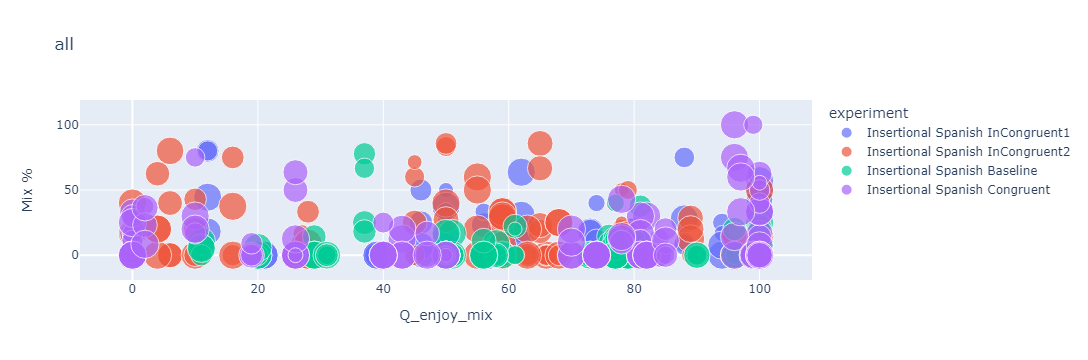

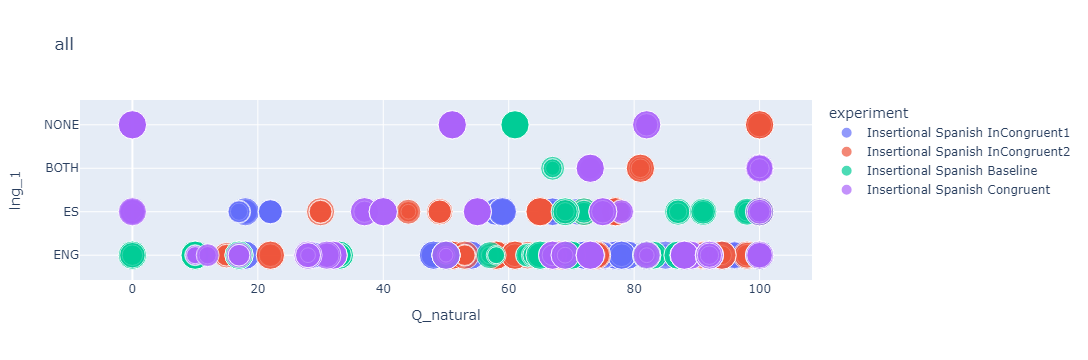

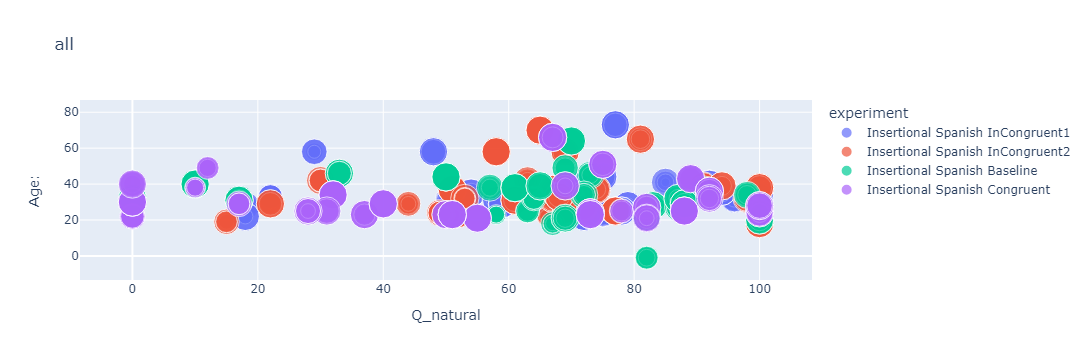

In [11]:
df_copy = get_experiment_df(experiments)
df_copy = remove_rename_columns(df_copy, False)
print(df_copy.shape)


# plot_corr_matt(df_copy, 'all')

plot_2d_scatter(df=df_copy,
        x="Q_natural",
        y="user number of utterances with some congruent switch",
        color='experiment',
        size='game_time',
        title=f'all')

plot_2d_scatter(df=df_copy,
        x="Q_natural",
        y="Q_enjoy_mix",
        color='experiment',
        size='game_time',
        title=f'all')

plot_2d_scatter(df=df_copy,
        x="Q_natural",
        y="Q_mix_friends",
        color='experiment',
        size='game_time',
        title=f'all')

plot_2d_scatter(df=df_copy,
        x="Q_natural",
        y="Mix %",
        color='experiment',
        size='game_time',
        title=f'all')

plot_2d_scatter(df=df_copy,
        x="Age:",
        y="user number of utterances with some congruent switch",
        color='experiment',
        size='game_time',
        title=f'all')

plot_2d_scatter(df=df_copy,
        x="Age:",
        y="Mix %",
        color='experiment',
        size='game_time',
        title=f'all')

plot_2d_scatter(df=df_copy,
        x="Q_mix_friends",
        y="Mix %",
        color='experiment',
        size='game_time',
        title=f'all')

plot_2d_scatter(df=df_copy,
        x="Q_enjoy_mix",
        y="Mix %",
        color='experiment',
        size='game_time',
        title=f'all')

plot_2d_scatter(df=df_copy,
        x="Q_natural",
        y="lng_1",
        color='experiment',
        size='game_time',
        title=f'all')

plot_2d_scatter(df=df_copy,
        x="Q_natural",
        y="Age:",
        color='experiment',
        size='game_time',
        title=f'all')

# for role in ['navigator', 'instructor']:
#     exp_df = get_experiment_df(experiments, role)
#     exp_df = remove_rename_columns(exp_df, False)
# #     plot_corr_matt(exp_df, f'all - {role}')

#     if role == 'navigator':
#         plot_2d_scatter(df=exp_df,
#         x="% entrainment - all dialog",
#         y="dist_score",
#         color='experiment',
#         size='game_time',
#         title=f'all - {role}')


#     plot_2d_scatter(df=exp_df,
#     x="% entrainment - all dialog",
#     y="Q_enjoy",
#     color='experiment',
#     size='game_time',
#     title=f'all - {role}')

In [6]:
# df['Enter your native language, or the language you are providing answers for, here:'].value_counts()
df_copy['lng_2'].value_counts()

lng_2
ES      260
ENG     136
NONE     40
Name: count, dtype: int64

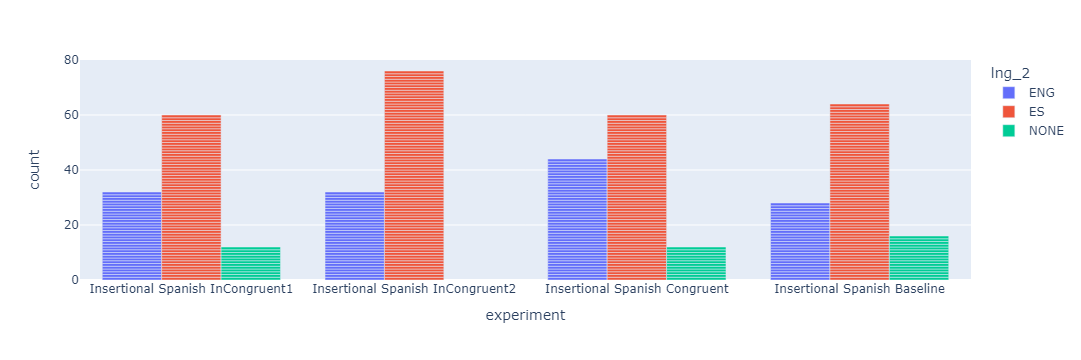

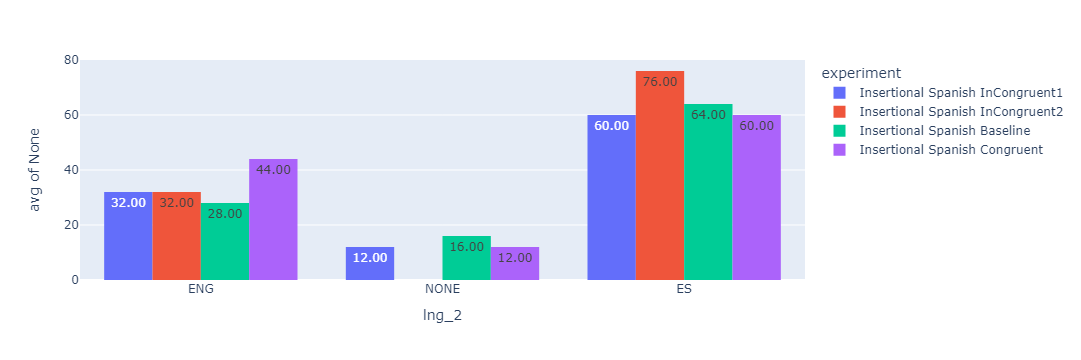

In [7]:
px.bar(df_copy,
             x='experiment',
             color='lng_2',
#                y='Q_enjoy',
               barmode="group"
            ).show()

px.histogram(df_copy,
             x='lng_2',
#              y='Q_enjoy',
             color='experiment',
             text_auto='.2f',
             histfunc='avg',
             barmode="group",
            ).show()
# px.bar(df_copy,
#              x='experiment',
#              color='lng_2',
#                barmode="group"
#             ).show()

Experiment comparison

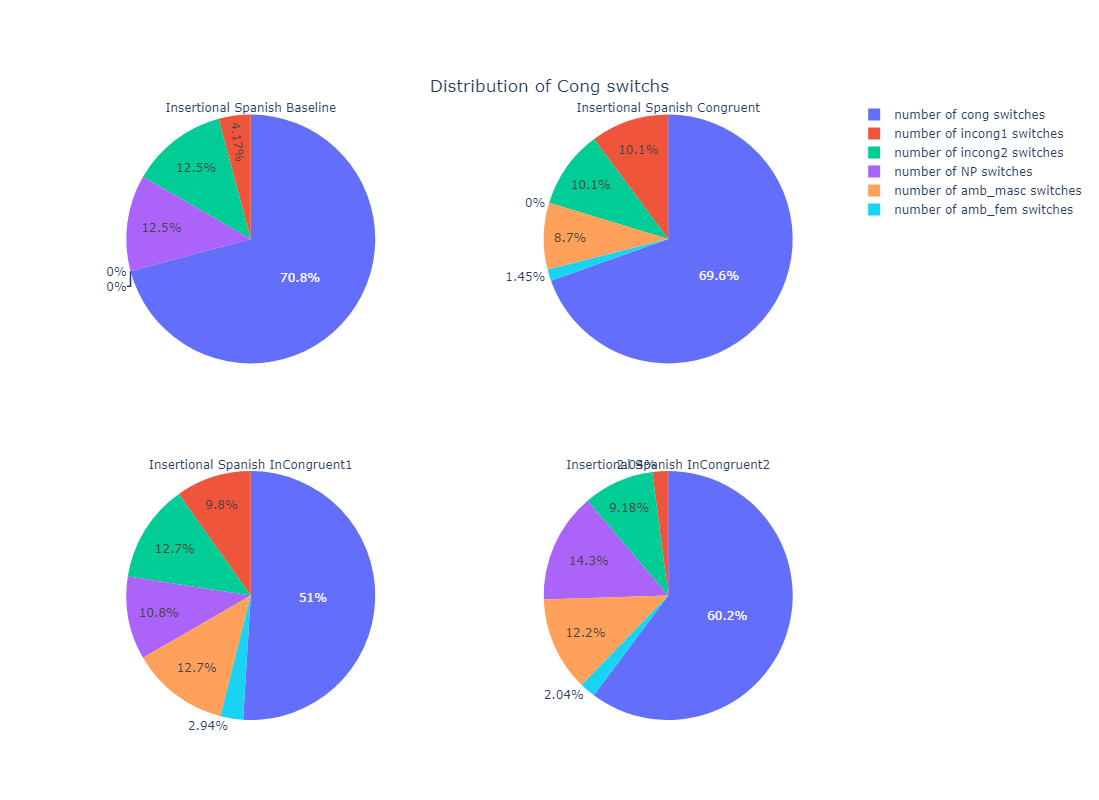

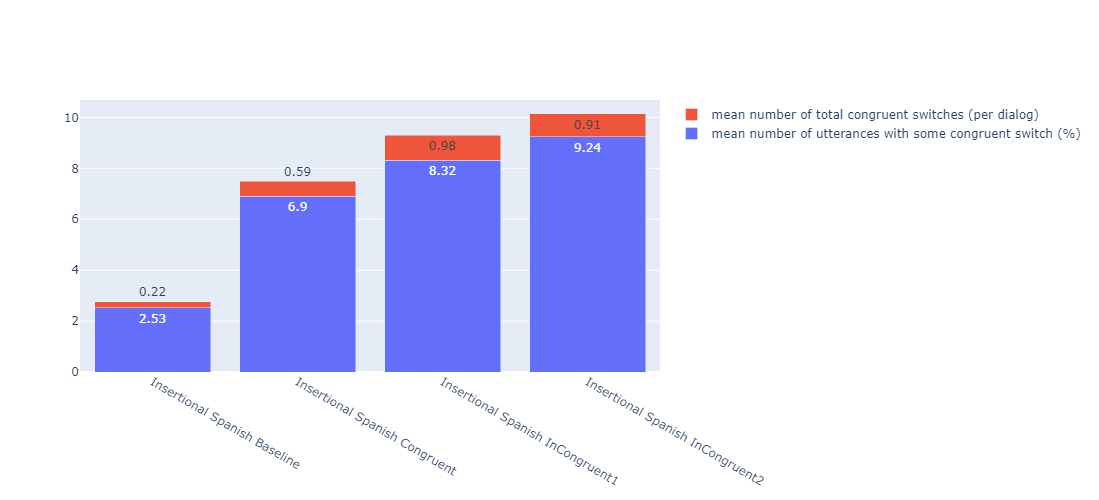

In [8]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def format_percentage(num: int) -> str:
    return round(num * 100, 2)

features=['user number of cong switches', 'user number of incong1 switches',
          'user number of incong2 switches', 'user number of NP switches', 'user number of amb_masc switches', 
          'user number of amb_fem switches']
pies=[]

mean_num_uter_w_cong_cs_normal_values = []
mean_num_of_total_cong_switch = []
for exp in experiments:
    exp_df = get_experiment_df([exp])
    exp_df = remove_rename_columns(exp_df)

    #bar plot
    mean_utters = np.mean(exp_df['user number of utterances'])
    mean_num_uter_w_cong_cs = np.mean(exp_df['user number of utterances with some congruent switch'])
    mean_num_uter_w_cong_cs_normal_values.append(format_percentage(mean_num_uter_w_cong_cs / mean_utters))

    mean_num_of_total_cong_switch.append(f"{np.mean(exp_df['user number of total congruent switches']):.2f}")
    # mean_num_of_total_cong_switch.append(np.mean(exp_df['user number of total congruent switches']))

    # distribution of cong types
    means_ = {}
    for f in features:
        means_[f] = np.mean(exp_df[f]) / np.mean(exp_df['user number of total congruent switches'])

    labels = list(means_.keys())
    labels = [l[5:] for l in labels]
    values = list(means_.values())
    pies.append(go.Pie(labels=labels,values=values, sort=False,title=exp))

    

opts = [(1,1), (1,2), (2,1), (2,2)]
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}]],
)

for idx, p in enumerate(pies):
    row, col = opts[idx]
    fig.add_trace(p,row=row, col=col)

# fig.update_layout(height=800, width=800)
    fig.update_layout(
    width=900,
    height=800,
    title={
    'text': 'Distribution of Cong switchs',
    'y':0.9,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Bar(x=experiments,
                        name='mean number of utterances with some congruent switch (%)',
                        y=mean_num_uter_w_cong_cs_normal_values,
                        text=mean_num_uter_w_cong_cs_normal_values))
fig.add_trace(go.Bar(x=experiments,
                        name='mean number of total congruent switches (per dialog)',
                        y=mean_num_of_total_cong_switch,
                        text=mean_num_of_total_cong_switch))

fig.update_layout(barmode='stack',width=1000,height=500)


fig.show()


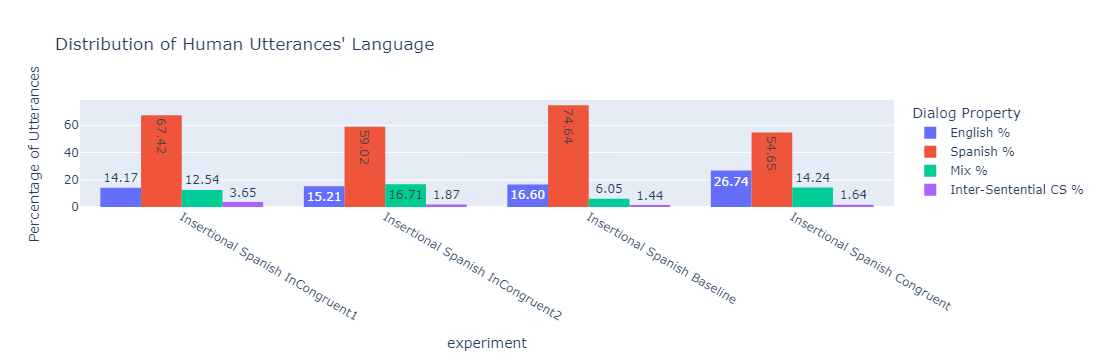

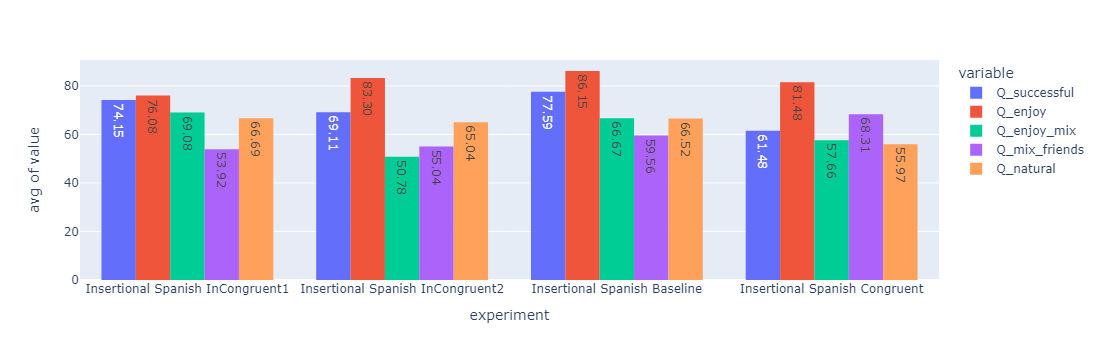

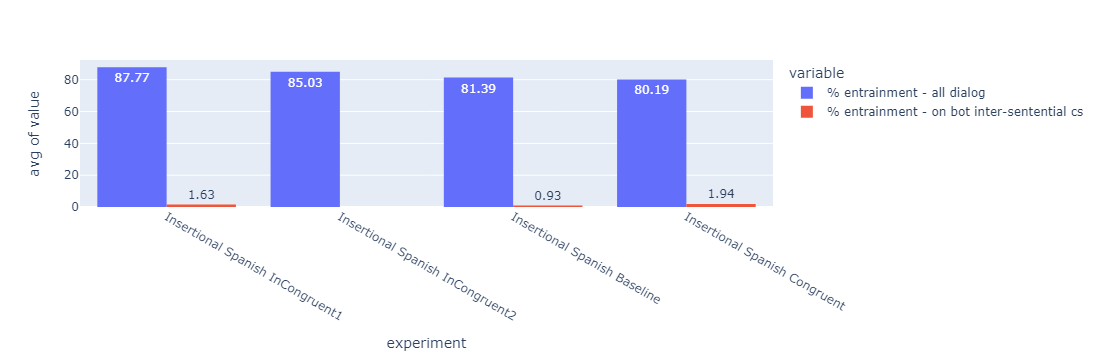

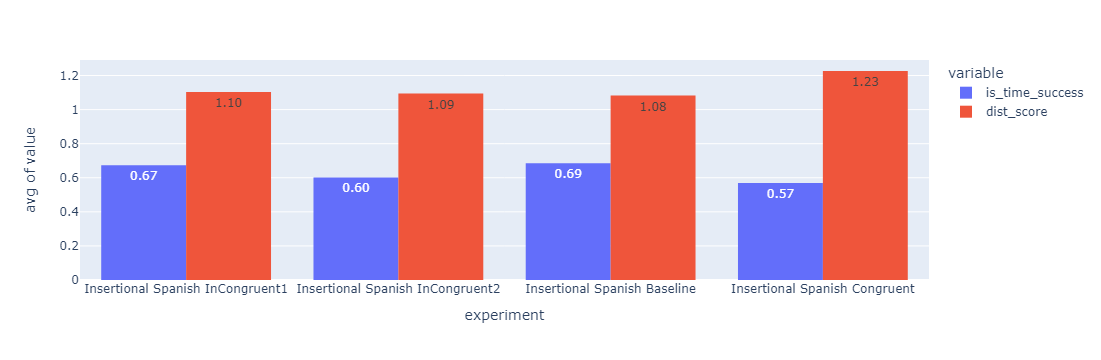

In [13]:
features=['English %', 'Spanish %', 'Mix %', "Inter-Sentential CS %"]
fig = px.histogram(df_copy,
             x='experiment',
             y=features,
             text_auto='.2f',
             histfunc='avg',
             barmode="group",
             title="Distribution of Human Utterances' Language",
            )

fig.update_layout(
    yaxis_title="Percentage of Utterances",
    legend_title="Dialog Property",
)
fig.show()



features=['Q_successful', 'Q_enjoy', 'Q_enjoy_mix', 'Q_mix_friends', 'Q_natural']
px.histogram(df_copy,
             x='experiment',
             y=features,
             text_auto='.2f',
             histfunc='avg',
             barmode="group",
            ).show()


px.histogram(df_copy,
             x='experiment',
             y=['% entrainment - all dialog','% entrainment - on bot inter-sentential cs'],
             text_auto='.2f',
             histfunc='avg',
             barmode="group",
            ).show()

features=['is_time_success', 'dist_score'] #'game_time']
px.histogram(df_copy,
             x='experiment',
             y=features,
             text_auto='.2f',
             histfunc='avg',
             barmode="group",
            ).show()